<a href="https://colab.research.google.com/github/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/05_EDA_Curate_Merge_Visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curate, Merge and Visualize Datasets

The ATOM Modeling PipeLine (AMPL; https://github.com/ATOMScience-org/AMPL) is an open-source, modular, extensible software pipeline for building and sharing models to advance in silico drug discovery.


## Scope of the tutorial

We will use the predownloaded ChEMBL datasets to carry out some of the following basic EDA using AMPL:  
* Load the data (two protein targets (PGP and BCRP) data)
* Clean
* Curate and Merge datasets
* Filter data 
* Carry out visualization 
* Carry out some basic analysis

Protein target information:
* PGP: PGP phosphoglycolate phosphatase. You can go the following link to learn about the gene, https://www.ncbi.nlm.nih.gov/gene/?term=283871
* BCRP or ABCG2: ATP binding cassette subfamily G member 2 (Junior blood group). You can go the following link to learn about the gene, https://www.ncbi.nlm.nih.gov/gene/9429

## Before you begin, make sure you close all other COLAB notebooks.

# Change Runtime settings
If you have access to COLAB-Pro (commercial/not-free), please change your runtime settings to use GPU and high-memory,

```Runtime --> Change Runtime Type --> GPU with high-RAM```

If you are not a paid COLAB-Pro customer, you can still choose GPU, with standard-RAM.

## Time to run the notebook on COLAB-Pro: ~ 4 minutes

In [1]:
!date # starting time

Fri Sep 17 12:52:03 UTC 2021


## Install AMPL

In [ ]:
! pip install rdkit-pypi
! pip install deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install -U --ignore-installed numba
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget 'https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh'

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

## Let us download the datasets from Github 

In [ ]:
# ABCB1 MDR1_human

! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/pgp_chembl.csv
# ABCG2 ABCG2_human
! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/bcrp_chembl.csv

In [5]:
%%bash
head bcrp*csv
echo ' '
head pgp*csv

,chembl,smile,pAct,relationship
0,BOERAVINONE G_CHEMBL221371,COc1cc(O)c2c(=O)c3c(oc2c1)C(OC)Oc1c(O)cccc1-3,6.16,=
1,BOERAVINONE H_CHEMBL222265,COc1cc2oc3c(c(=O)c2c(O)c1C)-c1cccc(O)c1OC3OC,5.6,=
2,None_CHEMBL243813,COc1cccc2[nH]c3ccccc3c(=O)c12,5.2,=
3,None_CHEMBL243169,COc1ccc2c(=O)c3cccc(C(=O)NCCc4ccc(OC)c(OC)c4)c3[nH]c2c1,5.86,=
4,None_CHEMBL243168,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccc(OC)cc4[nH]c23)cc1,6.25,=
5,None_CHEMBL243167,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccccc4[nH]c23)cc1OC,6.35,=
6,None_CHEMBL397235,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccccc4[nH]c23)cc1,6.46,=
7,None_CHEMBL242513,COc1cc(C(F)(F)F)cc2[nH]c3ccccc3c(=O)c12,6.11,=
8,None_CHEMBL243814,COc1cc(OC)c2c(=O)c3ccccc3[nH]c2c1,5.1,=
 
,chembl,smile,pAct,relationship
0,None_CHEMBL354935,COc1cc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)cccc43)c2)cc(OC)c1O,5.89,=
1,None_CHEMBL434871,COc1ccc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)cccc43)c2)cc1OC,5.39,=
2,None_CHEMBL354544,Cc1onc2c1c(=O)n(-c1cccc(CC(=O)Nc3ccc4c(c3)OCO4)c1)c1cccc(Cl)c21,5.4,=
3,

## Datasets were downloaded from ChEMBL database. Here are the details of the columns
* chembl provides the ChEMBL id or name 
* smiles contains the SMILE strings
* pACT is the pChEMBL value. pChEMBL is defined as: -Log(molar IC50, XC50, EC50, AC50, Ki, Kd or Potency).
* relationship shows whether a data point was censored or not. Not censored is marked by "=".

# Curate, merge and visualize data

Here we will load 2 datasets, curate the rows, and visualize some basic tenets of the data. **Your starting dataset should have columns including:**
- unique compound identifier
- smiles strings (see https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi for a good lookup service)
    - **IMPORTANT: for optimal harmonizaton, first translate all SMILES to pubchem SMILES using the linked service**
    - either look up pubchem CIDs for compounds or do SMILES -> SMILES
    - this greatly improves RDKit base_smiles_from_smiles reduction
- an assay measurement value, ie pIC50
- optional: 'relation' column indicating whether or not values are censored
- labels like "active" or "inactive" or another label you want, such as the source of the data.

## Load packages

In [6]:
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
import atomsci.ddm.utils.struct_utils as struct_utils
import atomsci.ddm.utils.curate_data as curate_data

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

# visualize data
import seaborn as sns
sns.set_context('poster')
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

# Curating and merging datasets
Some of these merging steps will be highly dependent on the information contained in each individual dataset and what you want to keep after curation.

### **Step 0:** Read dataset
Read in dataset to be curated and merged. 

### **Step 1:** Initial curation for nan's and outliers
Drop NA values for assay measurement column. Here you should also examine empty quotes, unexpected zeros, or other values that might not be real.

### **Step 2:** Canonicalize smiles strings
Canonicalize smiles strings so they are comparable across datasets with `struct_utils.base_smiles_from_smiles`. Even though the next function performs this step, we need to do this here in order to maintain correct metadata indices.

In [7]:
dfp = pd.read_csv("pgp_chembl.csv", index_col=0)

# Missing values for measurement column in this dataset
print("NA values:", dfp.pAct.isna().sum())
dfp.drop(dfp[dfp.pAct.isna()].index, inplace=True)

# canonicalize smiles strings
dfp['rdkit_smile'] = dfp['smile'].apply(curate_data.base_smiles_from_smiles)

#remove chemicals without smiles strings
print("NA SMILES:", (dfp.smile=='').sum()+dfp.smile.isna().sum())
dfp.drop(dfp[dfp.smile == ""].index, inplace=True)
dfp.drop(dfp[dfp.smile.isna()].index, inplace=True)

dfp.head()

NA values: 0
NA SMILES: 2


,chembl,smile,pAct,relationship,rdkit_smile
0,None_CHEMBL354935,COc1cc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)...,5.89,=,COc1cc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)...
1,None_CHEMBL434871,COc1ccc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl...,5.39,=,COc1ccc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl...
2,None_CHEMBL354544,Cc1onc2c1c(=O)n(-c1cccc(CC(=O)Nc3ccc4c(c3)OCO4...,5.40,=,Cc1onc2c1c(=O)n(-c1cccc(CC(=O)Nc3ccc4c(c3)OCO4...
3,None_CHEMBL172059,Cc1onc2c1c(=O)n(-c1cccc(CC(=O)Nc3ccc(C#N)cc3)c...,5.31,=,Cc1onc2c1c(=O)n(-c1cccc(CC(=O)Nc3ccc(C#N)cc3)c...
4,None_CHEMBL170699,COc1cc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)...,5.68,=,COc1cc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)...


In [8]:
dfp.describe()

,pAct
count,2447.000000
mean,5.835922
std,1.128850
min,4.000000
25%,5.080000
50%,5.700000
75%,6.400000
max,10.990000


In [9]:
# look at length of dataset and duplicates.
print('Name duplicates:', dfp['chembl'].duplicated().sum())
print('SMILES duplicates:', dfp.rdkit_smile.duplicated().sum())
print('Shape:',dfp.shape)

Name duplicates: 785
SMILES duplicates: 788
Shape: (2447, 5)


### **Step 3:** Aggregate assay data
Use the `aggregate_assay_data()` function to aggregate duplicate assay measurements, deal with censored values, and standardize measurement dataframe for modeling later. This method also re-does the canonical smiles strings. *Even if you know you have no duplicates, still perform this step to standardize the dataframe.* 

- `active_thresh` means the threshold value above/below which your compounds should be named 'active'/'inactive' or 1/0 for classification tasks. 
- here we pick 1uM (u = 10$^{-6}$) as our threshold and translate it into a pIC50 value to be the same as our data.

In [10]:
# threshold -> pIC50
import numpy as np
thresh=-np.log10(1/1000000)
thresh

6.0

In [11]:
dfp.head(3)

,chembl,smile,pAct,relationship,rdkit_smile
0,None_CHEMBL354935,COc1cc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)...,5.89,=,COc1cc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)...
1,None_CHEMBL434871,COc1ccc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl...,5.39,=,COc1ccc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl...
2,None_CHEMBL354544,Cc1onc2c1c(=O)n(-c1cccc(CC(=O)Nc3ccc4c(c3)OCO4...,5.40,=,Cc1onc2c1c(=O)n(-c1cccc(CC(=O)Nc3ccc4c(c3)OCO4...


In [12]:
#average duplicated data
dfp_cur = curate_data.aggregate_assay_data(dfp, 
                         value_col='pAct', 
                         output_value_col='pAct_pgp',
                         label_actives=True, 
                         active_thresh=thresh,
                         id_col='chembl', 
                         smiles_col='rdkit_smile', 
                         relation_col='relationship', 
                         date_col=None)


0 entries in input table are missing SMILES strings
1659 unique SMILES strings are reduced to 1659 unique base SMILES strings


In [13]:
dfp_cur

,compound_id,base_rdkit_smiles,relation,pAct_pgp,active
0,None_CHEMBL2449407,CCC(=O)c1ccccc1OC[C@H](O)CN1CCC(O)(c2ccccc2)CC1,,6.52,1
1,None_CHEMBL2372486,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H]([C...,,5.37,0
2,None_CHEMBL397350,CC(=O)O[C@H]1[C@@H](OC(=O)c2ccco2)C[C@@](C)(O)...,,5.66,0
3,None_CHEMBL2449323,CC(C)(C)OC(=O)C(Cc1ccccc1)N[C@@H]1c2cc(C#N)ccc...,,6.26,1
4,None_CHEMBL4285277,COc1cc2c(cc1OC)CN(Cc1ccc(-c3ccc(O)cc3)c(F)c1)CC2,,5.21,0
...,...,...,...,...,...
1654,None_CHEMBL375089,COc1ccc(OCC(O)CN2CCN(c3ccccc3C)CC2)c(C(=O)CCc2...,,6.75,1
1655,None_CHEMBL573233,Nc1nc(SCCc2ccccc2)nc2ccccc12,,5.96,0
1656,None_CHEMBL148260,O=C(c1ccccc1)c1ccccc1OCC(O)CN1CCC(O)(c2ccccc2)CC1,,6.51,1
1657,None_CHEMBL381164,COc1cc(OC)cc(-c2cccc(-c3ccc(O)cc3)c2)c1,,4.51,0


In [14]:
print('actives:', dfp_cur.active.sum(), ", inactives:", len(dfp_cur)-dfp_cur.active.sum())

actives: 644 , inactives: 1015


In [15]:
print("Total uncensored values:", len(dfp_cur[dfp_cur.relation == '']))

Total uncensored values: 1659


In [16]:
dfp_cur.columns

Index(['compound_id', 'base_rdkit_smiles', 'relation', 'pAct_pgp', 'active'], dtype='object')

In [17]:
print("Shape of curated dataframe:", dfp_cur.shape)

Shape of curated dataframe: (1659, 5)


### **Step 3.5**: Repeat
**Repeat** steps 1-3 for all dataframes you want to curate and merge.

In [18]:
dfb = pd.read_csv("bcrp_chembl.csv", index_col=0)
# Missing values for measurement column in this dataset
print("NA values:", dfb.pAct.isna().sum())

dfb.drop(dfb[dfb.pAct.isna()].index, inplace=True)

# canonicalize smiles strings
dfb['rdkit_smile'] = dfb['smile'].apply(curate_data.base_smiles_from_smiles)

#remove chemicals without smiles strings
print("NA SMILES:", (dfb.smile=='').sum()+dfb.smile.isna().sum())

dfb.drop(dfb[dfb.smile == ""].index, inplace=True)
dfb.drop(dfb[dfb.smile.isna()].index, inplace=True)

NA values: 0
NA SMILES: 0


In [19]:
# look at length of dataset and duplicates.
print('name dupes:', dfb['chembl'].duplicated().sum())
print('smiles dupes:', dfb.rdkit_smile.duplicated().sum())
print('shape:',dfb.shape)

name dupes: 494
smiles dupes: 494
shape: (1251, 5)


In [20]:
# BCRP
#run this for every pIC column
dfb_cur = curate_data.aggregate_assay_data(dfb, 
                         value_col='pAct', 
                         output_value_col='pAct_bcrp',
                         label_actives=True, 
                         active_thresh=thresh,
                         id_col='chembl', 
                         smiles_col='rdkit_smile', 
                         relation_col='relationship', 
                         date_col=None)
print('actives:', dfb_cur.active.sum(), ", inactives:", len(dfb_cur)-dfb_cur.active.sum())

0 entries in input table are missing SMILES strings
757 unique SMILES strings are reduced to 757 unique base SMILES strings
actives: 385 , inactives: 372


In [21]:
dfb_cur.columns

Index(['compound_id', 'base_rdkit_smiles', 'relation', 'pAct_bcrp', 'active'], dtype='object')

In [22]:
print("Total uncensored values:", len(dfb_cur[dfb_cur.relation == '']))
print("Shape of curated dataframe:", dfb_cur.shape)

Total uncensored values: 757
Shape of curated dataframe: (757, 5)


### **Step 4:** Filter for other outliers
### Filter large compounds
In general, molecular weight >2000 is removed



In [23]:
# calculate molecular weight
dfp_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in dfp_cur["base_rdkit_smiles"]]
dfb_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in dfb_cur["base_rdkit_smiles"]]

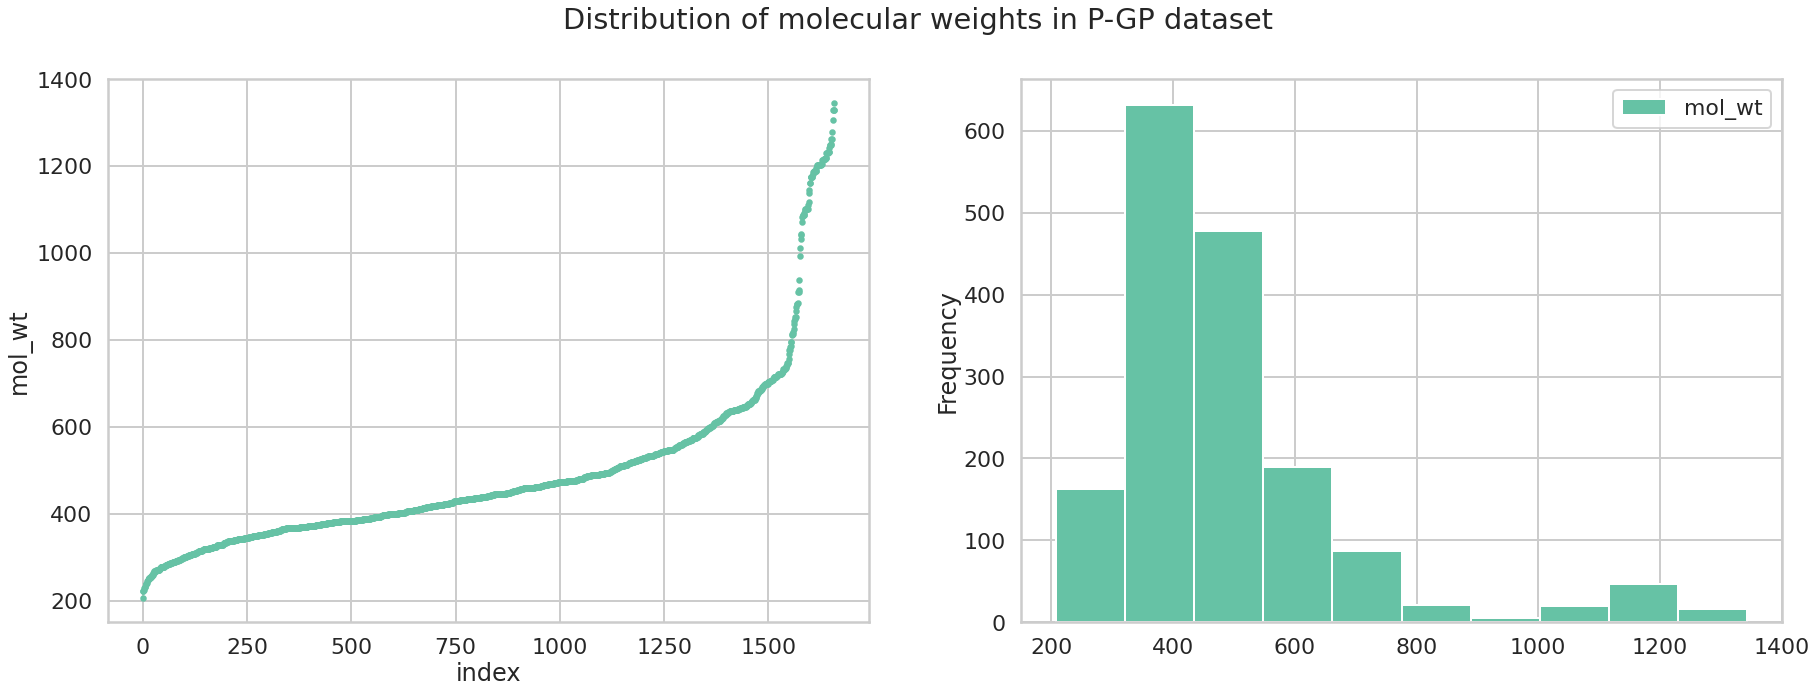

In [24]:
# visualize distribution of molecular weights
plot_df=dfp_cur
plot_df=plot_df.sort_values(by='mol_wt')
plot_df=plot_df.reset_index(drop=True)
plot_df=plot_df.reset_index()

fig,ax=plt.subplots(1,2, figsize=(30,10))
plot_df.plot(kind='scatter', x='index', y='mol_wt', color = pal[0], ax=ax[0])
plot_df.plot(kind='hist', x="index", y="mol_wt", color = pal[0], ax=ax[1])
fig.suptitle("Distribution of molecular weights in P-GP dataset");

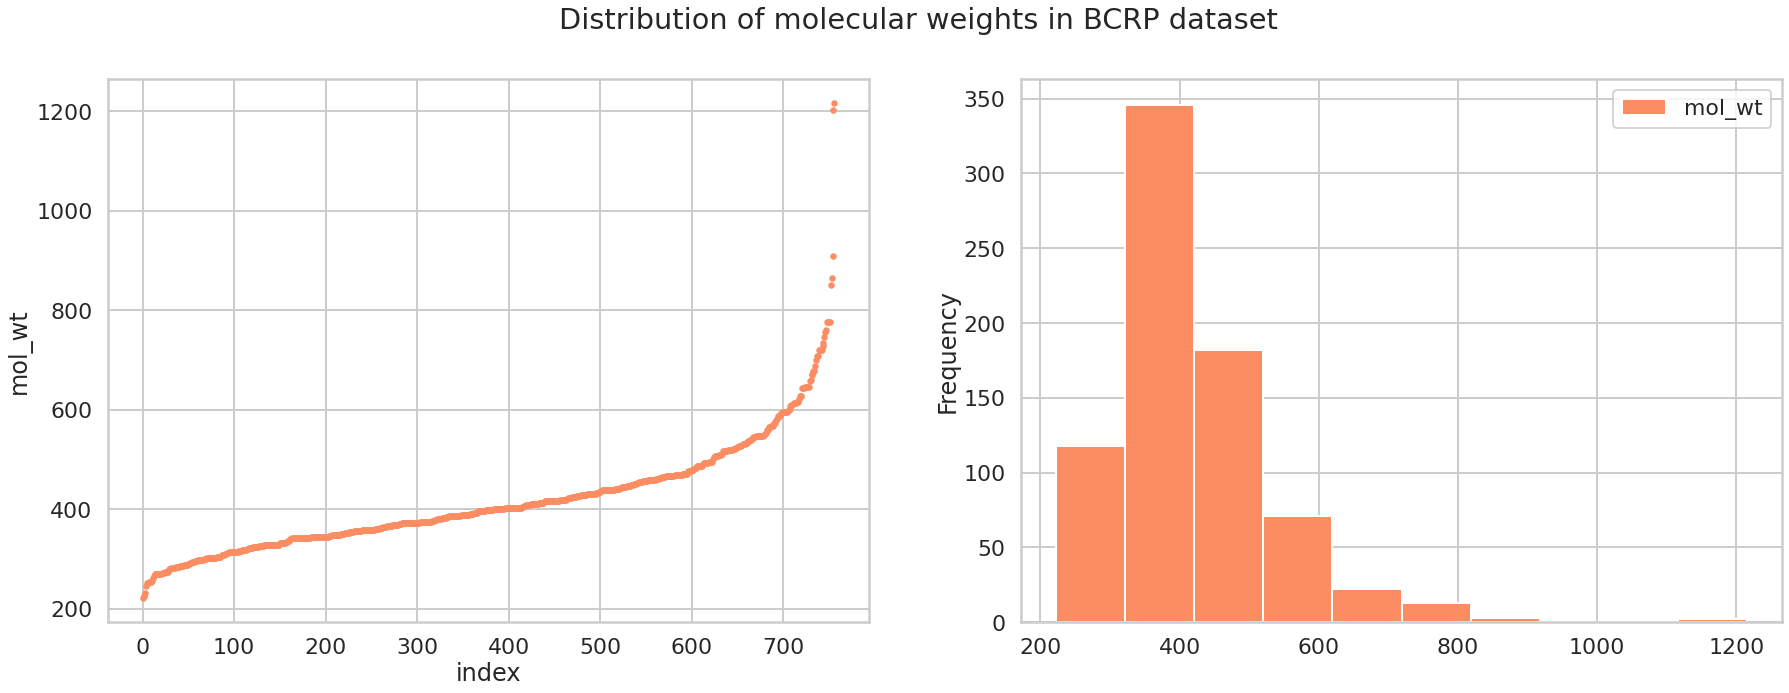

In [25]:
# visualize distribution of molecular weights
plot_df=dfb_cur
plot_df=plot_df.sort_values(by='mol_wt')
plot_df=plot_df.reset_index(drop=True)
plot_df=plot_df.reset_index()

fig,ax=plt.subplots(1,2, figsize=(30,10))
plot_df.plot(kind='scatter', x='index', y='mol_wt', color = pal[1], ax=ax[0])
plot_df.plot(kind='hist', x="index", y="mol_wt", color = pal[1], ax=ax[1])
fig.suptitle("Distribution of molecular weights in BCRP dataset");

In [26]:
# filter out high MWs
dfp_cur=dfp_cur[dfp_cur.mol_wt<2000]
dfb_cur=dfb_cur[dfb_cur.mol_wt<2000]

### Filter for outlier pIC50 values
In general, pIC50 values are between 2 and 14

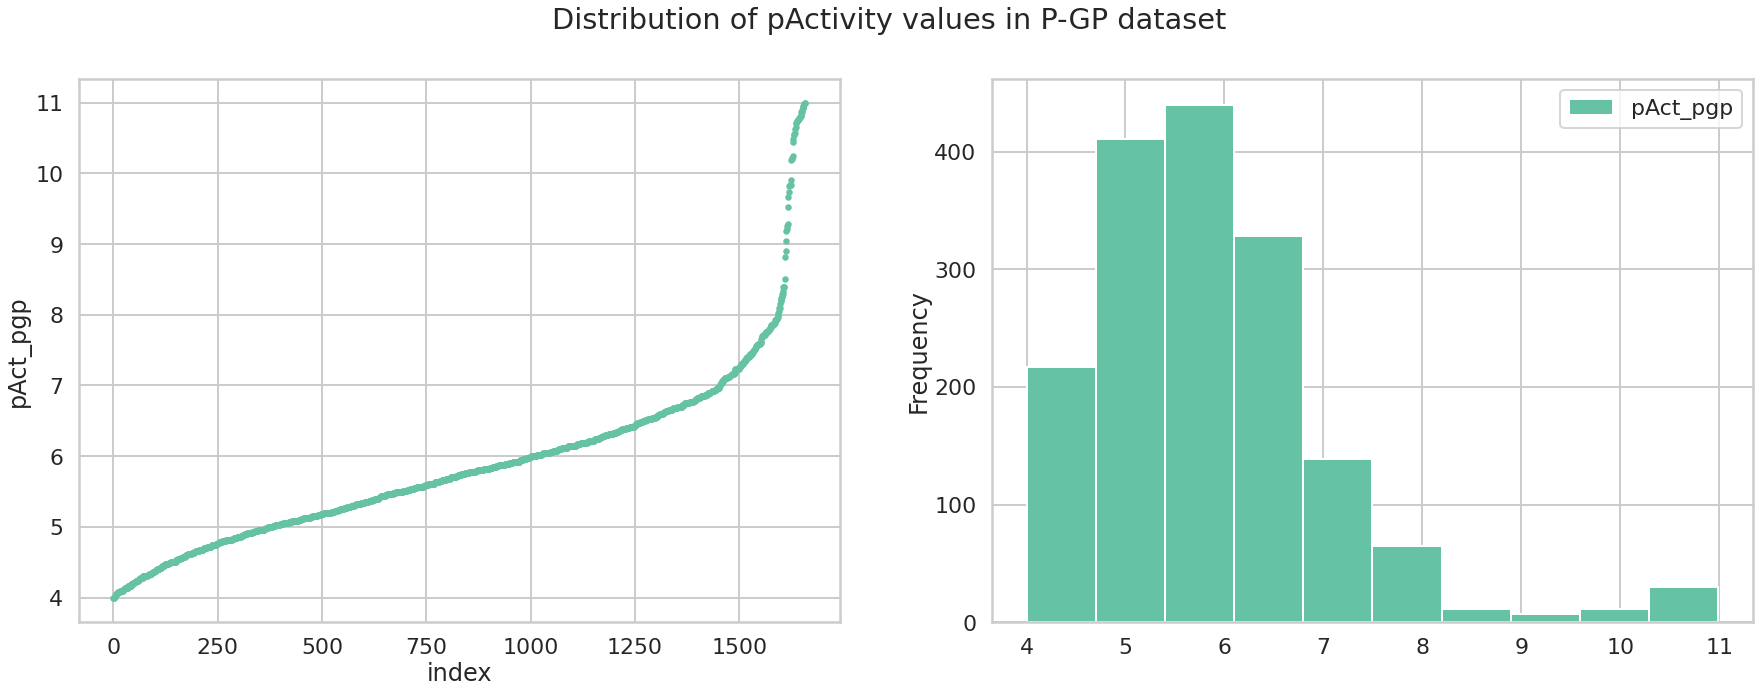

In [27]:
# visualize distribution of pActivity values
plot_df=dfp_cur
plot_df=plot_df.sort_values(by='pAct_pgp')
plot_df=plot_df.reset_index(drop=True)
plot_df=plot_df.reset_index()

fig,ax=plt.subplots(1,2, figsize=(30,10))
plot_df.plot(kind='scatter', x='index', y='pAct_pgp', color = pal[0], ax=ax[0])
plot_df.plot(kind='hist', x="index", y="pAct_pgp", color = pal[0], ax=ax[1])
fig.suptitle("Distribution of pActivity values in P-GP dataset");

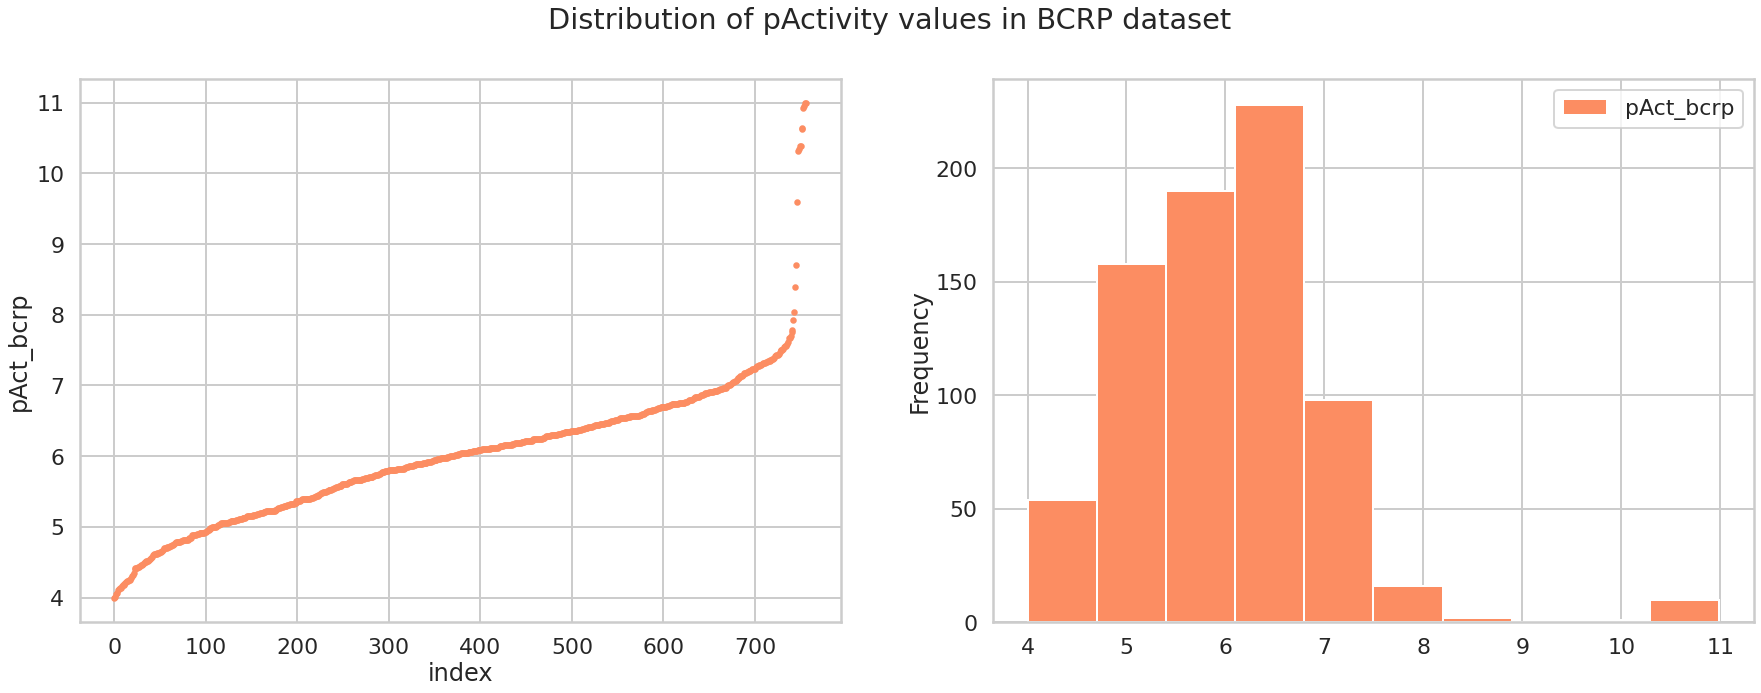

In [28]:
# visualize distribution of pActivity values
plot_df=dfb_cur
plot_df=plot_df.sort_values(by='pAct_bcrp')
plot_df=plot_df.reset_index(drop=True)
plot_df=plot_df.reset_index()

fig,ax=plt.subplots(1,2, figsize=(30,10))
plot_df.plot(kind='scatter', x='index', y='pAct_bcrp', color = pal[1], ax=ax[0])
plot_df.plot(kind='hist', x="index", y="pAct_bcrp", color = pal[1], ax=ax[1])
fig.suptitle("Distribution of pActivity values in BCRP dataset");

In [29]:
# filter high or low pIC50 values
dfp_cur=dfp_cur[dfp_cur.pAct_pgp<14]
dfp_cur=dfp_cur[dfp_cur.pAct_pgp>2]

dfb_cur=dfb_cur[dfb_cur.pAct_bcrp<14]
dfb_cur=dfb_cur[dfb_cur.pAct_bcrp>2]

### **Step 5**: (optional)  Merge datasets for multitask modeling
Merge processed assay values together for each dataframe.

In [30]:
print(dfp_cur.columns)
print(dfb_cur.columns)

Index(['compound_id', 'base_rdkit_smiles', 'relation', 'pAct_pgp', 'active',
       'mol_wt'],
      dtype='object')
Index(['compound_id', 'base_rdkit_smiles', 'relation', 'pAct_bcrp', 'active',
       'mol_wt'],
      dtype='object')


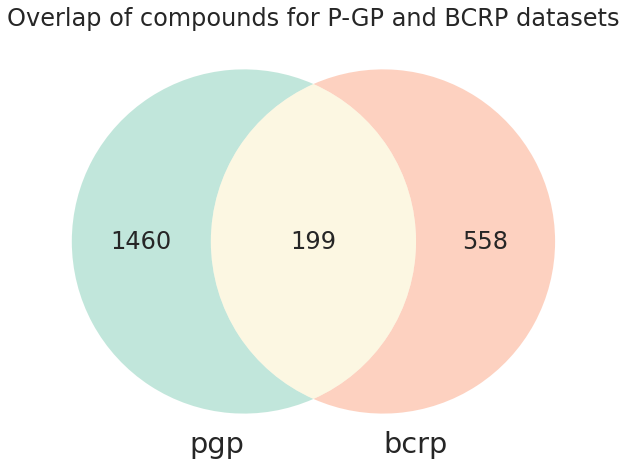

In [31]:
mpv.venn2_unweighted([set(dfp_cur["base_rdkit_smiles"]), set(dfb_cur["base_rdkit_smiles"])], set_labels = ("pgp", "bcrp"), set_colors = (pal[0], pal[1]))
plt.title('Overlap of compounds for P-GP and BCRP datasets');

In [32]:
# sanity check:
1659+757-199

2217

In [33]:
merge1 = pd.merge(dfp_cur, dfb_cur, how="outer", on=("compound_id", "base_rdkit_smiles", 'mol_wt'), suffixes = ("_pgp", "_bcrp"))
print("Shape of merge1 dataframe:", merge1.shape)
merge1.columns

Shape of merge1 dataframe: (2218, 9)


Index(['compound_id', 'base_rdkit_smiles', 'relation_pgp', 'pAct_pgp',
       'active_pgp', 'mol_wt', 'relation_bcrp', 'pAct_bcrp', 'active_bcrp'],
      dtype='object')

### **Step 6: Double check for duplicate and missing values**
Depending on your purpose, it may or may not matter if you have duplicates. Here we have a chemical with / without hydrochloride salt that reduces to the same base smiles. We will correct this single duplicate row. For more extensive differences, correct values in original csv's and start at step 1.

In [34]:
# check for missing or duplicate values: 
print("Name of dataset: merge1")
print("Length of dataset:", merge1.shape[0])

print("\nMissing compound_id entries:", merge1['compound_id'].isna().sum())
print("Duplicate chembl_ids:", merge1['compound_id'].duplicated().sum())

print("\nMissing SMILES:", merge1['base_rdkit_smiles'].isna().sum())
print("Duplicate SMILES:", merge1['base_rdkit_smiles'].duplicated().sum())

print("\nMissing values should only be target-specific now because not all compounds have all measurements:")
print("Other missing values:", merge1.columns[merge1.isna().any()].tolist())
print("Missing P-GP values:", merge1['pAct_pgp'].isna().sum())
print("Missing BCRP values:", merge1['pAct_bcrp'].isna().sum())

Name of dataset: merge1
Length of dataset: 2218

Missing compound_id entries: 0
Duplicate chembl_ids: 0

Missing SMILES: 0
Duplicate SMILES: 1

Missing values should only be target-specific now because not all compounds have all measurements:
Other missing values: ['relation_pgp', 'pAct_pgp', 'active_pgp', 'relation_bcrp', 'pAct_bcrp', 'active_bcrp']
Missing P-GP values: 559
Missing BCRP values: 1461


In [35]:
# what SMILES is duplicated, and why?
merge1[merge1.base_rdkit_smiles.duplicated(keep=False)]

,compound_id,base_rdkit_smiles,relation_pgp,pAct_pgp,active_pgp,mol_wt,relation_bcrp,pAct_bcrp,active_bcrp
1292,ELACRIDAR HYDROCHLORIDE_CHEMBL2074730,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cccc4c(=O)c5...,,6.383,1.0,563.242021,NaN,NaN,NaN
1789,ELACRIDAR_CHEMBL396298,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cccc4c(=O)c5...,NaN,NaN,NaN,563.242021,,6.593333,1.0


In [36]:
# manually fix these rows
merge1.loc[merge1.index==1916, 'relation_pgp'] = merge1.iloc[203].relation_pgp
merge1.loc[merge1.index==1916, 'pAct_pgp'] = merge1.iloc[203].pAct_pgp
merge1.loc[merge1.index==1916, 'active_pgp'] = merge1.iloc[203].active_pgp
merge1=merge1.drop(index=203)

print('Fixed row:')
display(merge1[merge1.index==1916])
print('\nRemaining duplicates:')
display(merge1[merge1.base_rdkit_smiles.duplicated(keep=False)])
print('\nShape of deduplicated dataframe:', merge1.shape)


Fixed row:


,compound_id,base_rdkit_smiles,relation_pgp,pAct_pgp,active_pgp,mol_wt,relation_bcrp,pAct_bcrp,active_bcrp
1916,None_CHEMBL4204291,COCCOc1cc2c(cc1OC)CCN(CC(=O)c1ccc(C)c(NC(=O)c3...,,6.22,1.0,539.242021,,4.63,0.0



Remaining duplicates:


,compound_id,base_rdkit_smiles,relation_pgp,pAct_pgp,active_pgp,mol_wt,relation_bcrp,pAct_bcrp,active_bcrp
1292,ELACRIDAR HYDROCHLORIDE_CHEMBL2074730,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cccc4c(=O)c5...,,6.383,1.0,563.242021,NaN,NaN,NaN
1789,ELACRIDAR_CHEMBL396298,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cccc4c(=O)c5...,NaN,NaN,NaN,563.242021,,6.593333,1.0



Shape of deduplicated dataframe: (2217, 9)


### **Step 6.5:** repeat

In [37]:
# check for missing or duplicate values: 
print("Name of dataset: dfp_cur")
print("Length of dataset:", dfp_cur.shape[0])

print("\nMissing compound_id entries:", dfp_cur['compound_id'].isna().sum())
print("Duplicate chembl_ids:", dfp_cur['compound_id'].duplicated().sum())

print("\nMissing SMILES:", dfp_cur['base_rdkit_smiles'].isna().sum())
print("Duplicate SMILES:", dfp_cur['base_rdkit_smiles'].duplicated().sum())

print("\nOther missing values:", dfp_cur.columns[dfp_cur.isna().any()].tolist())
print("Missing P-GP values:", dfp_cur['pAct_pgp'].isna().sum())

Name of dataset: dfp_cur
Length of dataset: 1659

Missing compound_id entries: 0
Duplicate chembl_ids: 0

Missing SMILES: 0
Duplicate SMILES: 0

Other missing values: []
Missing P-GP values: 0


In [38]:
# check for missing or duplicate values: 
print("Name of dataset: dfb_cur")
print("Length of dataset:", dfb_cur.shape[0])

print("\nMissing compound_id entries:", dfb_cur['compound_id'].isna().sum())
print("Duplicate chembl_ids:", dfb_cur['compound_id'].duplicated().sum())

print("\nMissing SMILES:", dfb_cur['base_rdkit_smiles'].isna().sum())
print("Duplicate SMILES:", dfb_cur['base_rdkit_smiles'].duplicated().sum())

print("\nOther missing values:", dfb_cur.columns[dfb_cur.isna().any()].tolist())
print("Missing BCRP values:", dfb_cur['pAct_bcrp'].isna().sum())

Name of dataset: dfb_cur
Length of dataset: 757

Missing compound_id entries: 0
Duplicate chembl_ids: 0

Missing SMILES: 0
Duplicate SMILES: 0

Other missing values: []
Missing BCRP values: 0


### **Step 7:** Save dataframes

In [39]:
!pwd

/content


In [40]:
dfp_cur.to_csv("pgp_curated.csv")
dfb_cur.to_csv("bcrp_curated.csv")
merge1.to_csv("pgp_bcrp_merged.csv")

## Optional steps:

If you want to save the files, then mount your Google Drive and copy it to a directory of your choice

In [41]:
# from google.colab import drive
# drive.mount('/content/drive')

In [42]:
#copy files back to google drive to use them for other notebooks.
# %%bash

# cp /content/bcrp_curated.csv /content/drive/My\ Drive/
# cp /content/pgp_curated.csv /content/drive/My\ Drive/
# cp /content/pgp_bcrp_merged.csv /content/drive/My\ Drive/
# cp /content/pgp_chembl.csv /content/drive/My\ Drive/
# cp /content/bcrp_chembl.csv /content/drive/My\ Drive/

In [43]:
!ls -l 

total 908
-rw-r--r-- 1 root root 106807 Sep 17 12:53 bcrp_chembl.csv
-rw-r--r-- 1 root root  78057 Sep 17 12:53 bcrp_curated.csv
drwxr-xr-x 5 root root   4096 Sep 17 12:52 github
-rwxr--r-- 1 root root   1124 Sep 17 12:52 install_AMPL_GPU_test.sh
-rw-r--r-- 1 root root 265411 Sep 17 12:53 pgp_bcrp_merged.csv
-rw-r--r-- 1 root root 261853 Sep 17 12:53 pgp_chembl.csv
-rw-r--r-- 1 root root 194996 Sep 17 12:53 pgp_curated.csv
drwxr-xr-x 1 root root   4096 Sep  1 19:26 sample_data


In [44]:
!date

Fri Sep 17 12:53:34 UTC 2021


In [45]:
!echo "done"

done
